In [83]:
import numpy as np
import matplotlib.pyplot as plt
import jax

import icomo
from tapm import utils

0.25

In [84]:
def m(args):
    return args["m_max"] - args["m_max"] / args["H_thres"] * args[
        "m_eps"
    ] * jax.numpy.log(1 + jax.numpy.exp((args["H_thres"] - args["H"]) / args["m_eps"]))


def lambda_STI(args):
    return (
        args["lambda_0"]
        + args["c"] * (1 - m(args)) * args["beta_HIV"] * args["H"] * (1 - args["P_HIV"])
        + args["lambda_P"] * args["P_HIV"]
    )


def infect(y, args):
    return (1 - m(args) * (1 - args["P_HIV"])) * args["beta_STI"] * y["I_STI"]


def model(t, y, args):
    cm = icomo.CompModel(y)

    # basic STI dynamics
    cm.flow("S_STI", "I_STI", args["asymptomatic"] * infect(y, args))
    cm.flow("S_STI", "T_STI", (1 - args["asymptomatic"]) * infect(y, args))
    cm.flow("I_STI", "S_STI", args["gamma_STI"])
    cm.flow("I_STI", "T_STI", lambda_STI(args))
    cm.flow("T_STI", "S_STI", args["gammaT_STI"])
    # vital dynamics
    cm.flow("I_STI", "S_STI", args["mu"])
    cm.flow("T_STI", "S_STI", args["mu"])

    #    cm.view_graph()
    return cm.dy


args = {
    "beta_HIV": 0.6341 / 360.0,
    "beta_STI": 0.0016 * 5.0,
    "mu": 1.0 / 45.0 / 360.0,
    "gamma_STI": 1.0 / 1.32 / 360.0,
    "gammaT_STI": 1.0 / 14.0,
    #    "gammaT_STI": 1./7.,
    "lambda_0": 0.0,
    "lambda_P": 1 / 3 / 360,
    #    "lambda_P": 12./9./360.,
    "asymptomatic": 0.9,
    ####
    "m_max": 0.8,
    "H_thres": 0.1,
    "m_eps": 0.01,
    "Phi_r": 40.0,
    "H_tau": 20.0,
    "c": 50.0,
    "H": 0.0,
    "P_HIV": 0.0,
}

y0 = {
    "S_STI": 0.99,
    "I_STI": 0.01,
    "T_STI": 0.0,
}

In [85]:
ts = np.linspace(0, 3600 * 5, 3600)
integrator_object = icomo.ODEIntegrator(
    ts_out=ts,
    t_0=min(ts),
    ts_solver=ts,
)

integrator = integrator_object.get_func(model)

In [86]:
Hs = np.linspace(0, 0.15, 101)
Ps = np.linspace(0, 0.9, 201)
lambda_P_values = [
    6 / 360,
    5 / 360,
    4 / 360,
    3 / 360,
    2.5 / 360,
    2 / 360,
    1.5 / 360,
    1 / 360,
]

results = {}

for lambda_P in lambda_P_values:
    res_size = [len(Hs), len(Ps)]
    res_I = np.zeros(res_size)
    res_T = np.zeros(res_size)
    res_infections = np.zeros(res_size)
    res_tests = np.zeros(res_size)
    check = np.zeros(res_size)

    for i, H in enumerate(Hs):
        for j, P in enumerate(Ps):
            args_mod = args.copy()
            args_mod["H"] = H
            args_mod["P_HIV"] = P
            args_mod["lambda_P"] = lambda_P
            output = integrator(y0=y0, constant_args=args_mod)

            y1 = {key: value[-1] for key, value in output.items()}
            res_I[i, j] = output["I_STI"][-1]
            res_T[i, j] = output["T_STI"][-1]
            res_infections[i, j] = infect(y1, args_mod) * y1["S_STI"]
            res_tests[i, j] = lambda_STI(args_mod) * y1["I_STI"]
            check[i, j] = abs(output["I_STI"][-1] - output["I_STI"][-101]) + abs(
                output["T_STI"][-1] - output["T_STI"][-101]
            )

    results[lambda_P] = {
        "res_I": res_I,
        "res_T": res_T,
        "res_infections": res_infections,
        "res_tests": res_tests,
        "check": check,
    }

print(check.max())

0.0003003318955066105


<>:30: SyntaxWarning: invalid escape sequence '\l'
<>:30: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PMallick\AppData\Local\Temp\ipykernel_29708\3396174110.py:30: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")


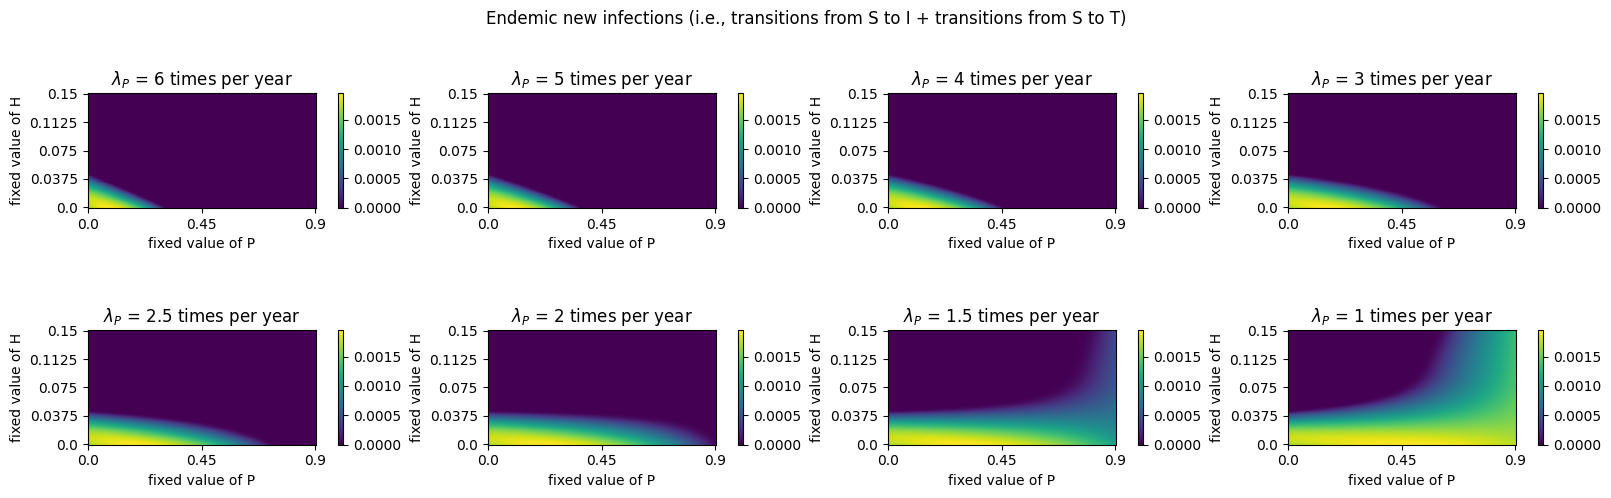

In [87]:
# Plotting
lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2.5 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
]

# Determine the global vmin and vmax
all_infections = np.concatenate(
    [results[lambda_P]["res_infections"].flatten() for lambda_P in lambda_P_values]
)
global_vmin = np.min(all_infections)
global_vmax = np.max(all_infections)


num_lambda_P = len(lambda_P_values)
fig, axes = plt.subplots(
    2, num_lambda_P // 2, figsize=(4 * num_lambda_P // 2, 5), constrained_layout=True
)

for idx, lambda_P in enumerate(lambda_P_values):
    ax = axes.flat[idx]
    res_infections = results[lambda_P]["res_infections"]
    cax = ax.imshow(res_infections, origin="lower", vmin=global_vmin, vmax=global_vmax)
    ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")
    ax.set_xlabel("fixed value of P")
    ax.set_ylabel("fixed value of H")
    ax.set_xticks([0, 100, 200])
    ax.set_xticklabels([Ps[0], 0.45, Ps[200]])
    ax.set_yticks([0, 25, 50, 75, 100])
    ax.set_yticklabels([Hs[0], Hs[25], Hs[50], Hs[75], Hs[100]])
    fig.colorbar(cax, ax=ax, shrink=0.5)


fig.suptitle(
    "Endemic new infections (i.e., transitions from S to I + transitions from S to T)"
)

plt.show()

<>:58: SyntaxWarning: invalid escape sequence '\l'
<>:58: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PMallick\AppData\Local\Temp\ipykernel_29708\2749010724.py:58: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")


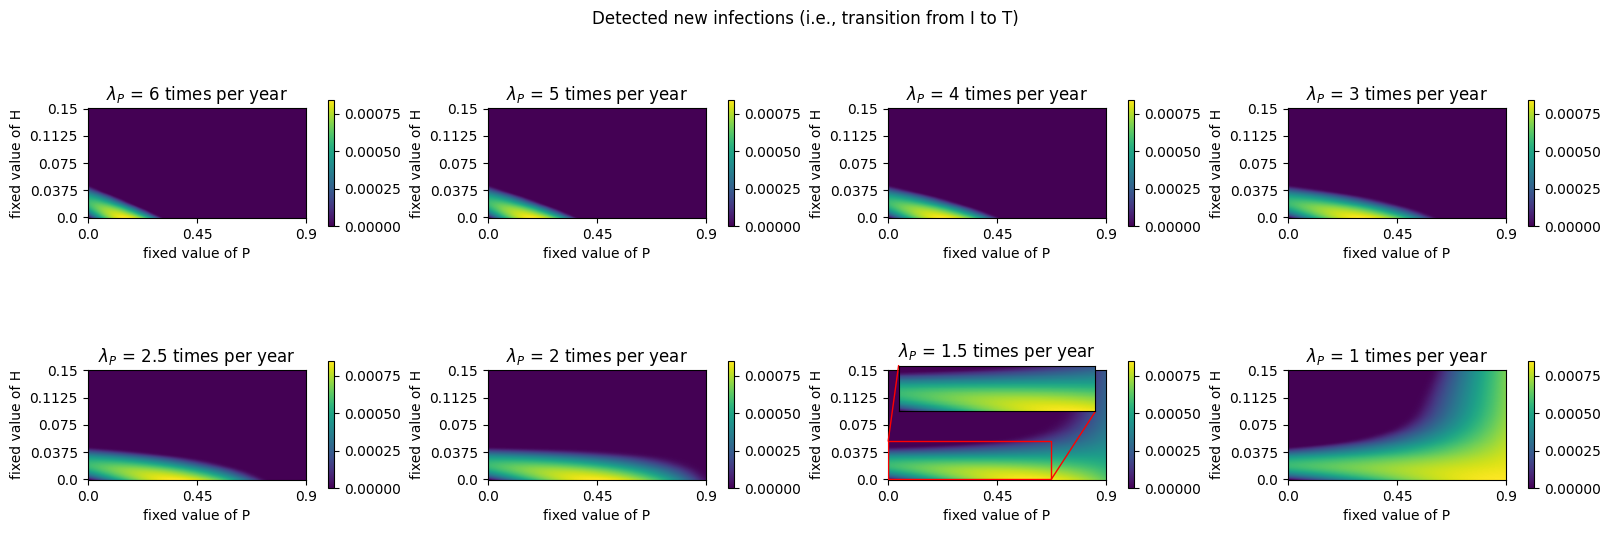

In [111]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

Hs = np.linspace(0, 0.15, 101)


Ps = np.linspace(0, 0.9, 201)


# Plotting


lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2.5 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
]


# Determine the global vmin and vmax


all_infections = np.concatenate(
    [results[lambda_P]["res_tests"].flatten() for lambda_P in lambda_P_values]
)


global_vmin = np.min(all_infections)


global_vmax = np.max(all_infections)


num_lambda_P = len(lambda_P_values)


fig, axes = plt.subplots(
    2, num_lambda_P // 2, figsize=(4 * num_lambda_P // 2, 5.5), constrained_layout=True
)


for idx, lambda_P in enumerate(lambda_P_values):

    ax = axes.flat[idx]

    res_tests = results[lambda_P]["res_tests"]

    cax = ax.imshow(res_tests, origin="lower", vmin=global_vmin, vmax=global_vmax)

    ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")

    ax.set_xlabel("fixed value of P")

    ax.set_ylabel("fixed value of H")

    ax.set_xticks([0, 100, 200])

    ax.set_xticklabels([Ps[0], 0.45, Ps[200]])

    ax.set_yticks([0, 25, 50, 75, 100])

    ax.set_yticklabels([Hs[0], Hs[25], Hs[50], Hs[75], Hs[100]])

    fig.colorbar(cax, ax=ax, shrink=0.5)

    # Add inset for lambda_P = 1.5/360
    if lambda_P == 1.5 / 360:
        inset_ax = ax.inset_axes(
            [0.05, 0.23, 0.9, 1.2], xlim=(0, 150), ylim=(0, 35)
        )  # [left, bottom, width, height]
        inset_ax.imshow(res_tests, origin="lower", vmin=global_vmin, vmax=global_vmax)
        inset_ax.set_xticks([])
        inset_ax.set_yticks([])

        # inset_ax.set_title("Inset", fontsize=8)
        ax.indicate_inset_zoom(inset_ax, edgecolor="red", alpha=1)


fig.suptitle("Detected new infections (i.e., transition from I to T)")


plt.show()

<>:26: SyntaxWarning: invalid escape sequence '\l'
<>:26: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PMallick\AppData\Local\Temp\ipykernel_29708\3164157755.py:26: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")


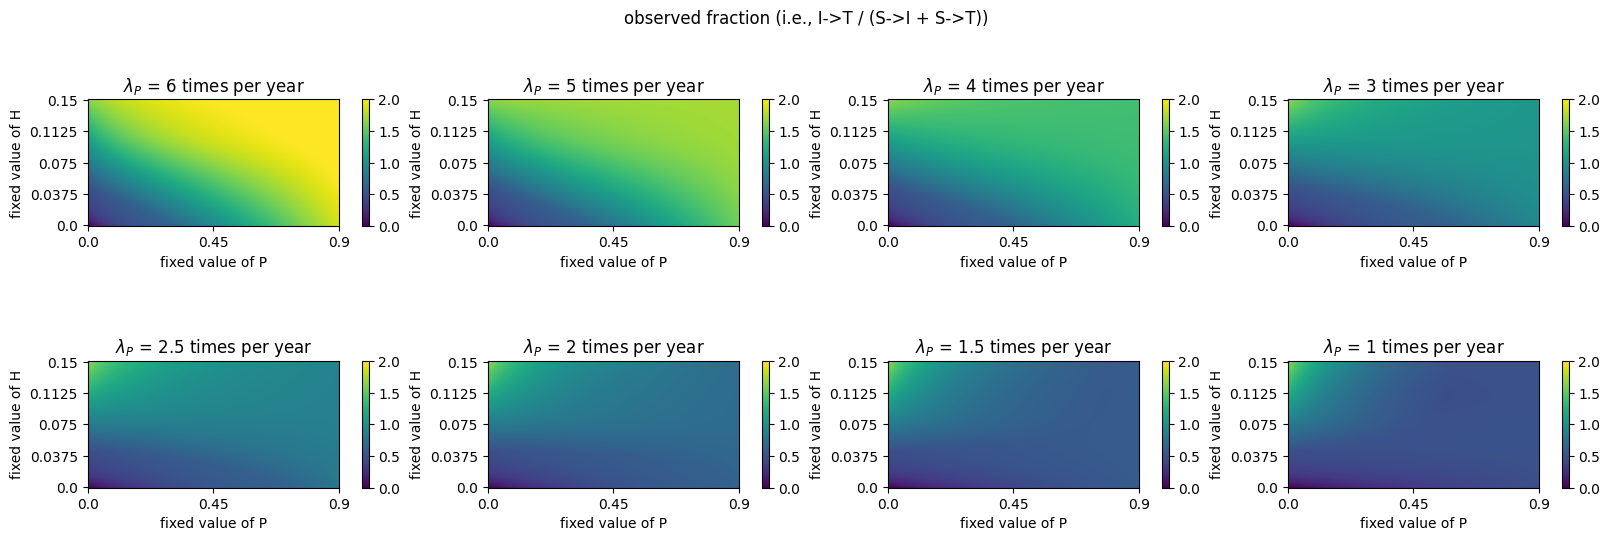

In [112]:
Hs = np.linspace(0, 0.15, 101)
Ps = np.linspace(0, 0.9, 201)
# Plotting
lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2.5 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
]

num_lambda_P = len(lambda_P_values)
fig, axes = plt.subplots(
    2, num_lambda_P // 2, figsize=(4 * num_lambda_P // 2, 5.5), constrained_layout=True
)


for idx, lambda_P in enumerate(lambda_P_values):
    ax = axes.flat[idx]
    res_infections = results[lambda_P]["res_infections"]
    res_tests = results[lambda_P]["res_tests"]
    cax = ax.imshow(res_tests / res_infections, origin="lower", vmin=0, vmax=2)
    ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")
    ax.set_xlabel("fixed value of P")
    ax.set_ylabel("fixed value of H")
    ax.set_xticks([0, 100, 200])
    ax.set_xticklabels([Ps[0], 0.45, Ps[200]])
    ax.set_yticks([0, 25, 50, 75, 100])
    ax.set_yticklabels([Hs[0], Hs[25], Hs[50], Hs[75], Hs[100]])
    fig.colorbar(cax, ax=ax, shrink=0.5)
fig.suptitle("observed fraction (i.e., I->T / (S->I + S->T))")

plt.show()

<>:25: SyntaxWarning: invalid escape sequence '\l'
<>:25: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PMallick\AppData\Local\Temp\ipykernel_38280\3721642146.py:25: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")


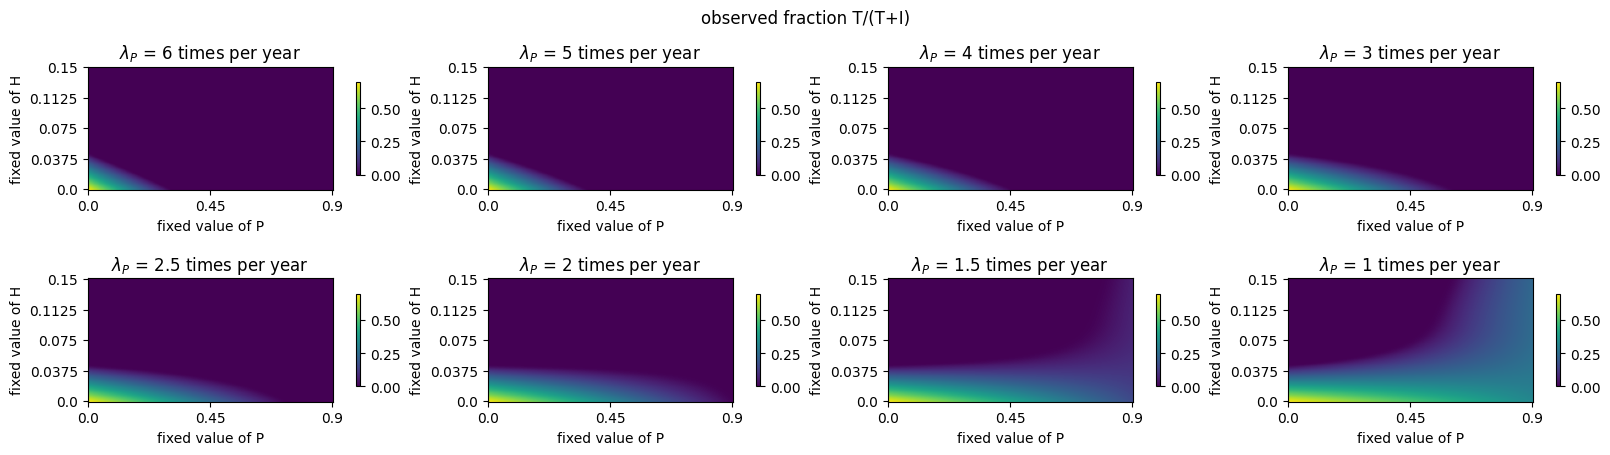

In [24]:
# Hs = np.linspace(0, 0.15, 101)
# Ps = np.linspace(0, 0.9, 201)
# # Plotting
# lambda_P_labels = [
#     "6 times per year",
#     "5 times per year",
#     "4 times per year",
#     "3 times per year",
#     "2.5 times per year",
#     "2 times per year",
#     "1.5 times per year",
#     "1 times per year",
# ]
# num_lambda_P = len(lambda_P_values)
# fig, axes = plt.subplots(
#     2, num_lambda_P // 2, figsize=(4 * num_lambda_P // 2, 4.5), constrained_layout=True
# )


# for idx, lambda_P in enumerate(lambda_P_values):
#     ax = axes.flat[idx]
#     res_I = results[lambda_P]["res_I"]
#     res_T = results[lambda_P]["res_T"]
#     cax = ax.imshow(res_I - res_T, origin="lower", vmin=0, vmax=0.7)
#     ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")
#     ax.set_xlabel("fixed value of P")
#     ax.set_ylabel("fixed value of H")
#     ax.set_xticks([0, 100, 200])
#     ax.set_xticklabels([Ps[0], 0.45, Ps[200]])
#     ax.set_yticks([0, 25, 50, 75, 100])
#     ax.set_yticklabels([Hs[0], Hs[25], Hs[50], Hs[75], Hs[100]])
#     fig.colorbar(cax, ax=ax, shrink=0.5)
# fig.suptitle("observed fraction T/(T+I)")

# plt.show()

<>:43: SyntaxWarning: invalid escape sequence '\l'
<>:52: SyntaxWarning: invalid escape sequence '\l'
<>:43: SyntaxWarning: invalid escape sequence '\l'
<>:52: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PMallick\AppData\Local\Temp\ipykernel_29708\3449121660.py:43: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")
C:\Users\PMallick\AppData\Local\Temp\ipykernel_29708\3449121660.py:52: SyntaxWarning: invalid escape sequence '\l'
  "$\lambda_{STI}$ = $\lambda_H \cdot (1-P) $ + $\lambda_P \cdot P$",


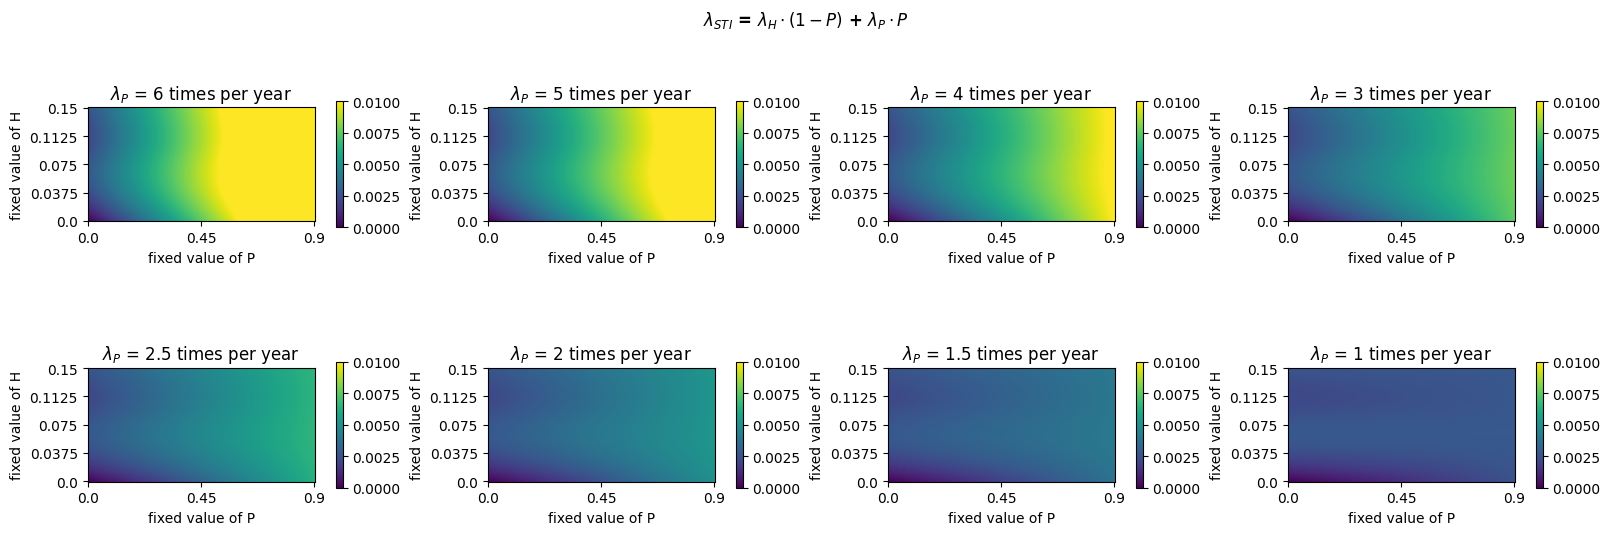

In [113]:
# Define parameters
Hs = np.linspace(0, 0.15, 101)
Ps = np.linspace(0, 0.9, 201)


# Define m function
def compute_m(args, H):
    return args["m_max"] - args["m_max"] / args["H_thres"] * args["m_eps"] * np.log(
        1 + np.exp((args["H_thres"] - H) / args["m_eps"])
    )


lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2.5 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
]

# Plotting
num_lambda_P = len(lambda_P_values)
fig, axes = plt.subplots(
    2, num_lambda_P // 2, figsize=(4 * num_lambda_P // 2, 5.5), constrained_layout=True
)

for idx, lambda_P_val in enumerate(lambda_P_values):
    lambda_H = np.zeros([len(Hs), len(Ps)])
    lambda_P = np.zeros([len(Hs), len(Ps)])

    for i, H in enumerate(Hs):
        for j, P in enumerate(Ps):
            m = compute_m(args, H)
            lambda_H[i, j] = args["c"] * (1 - m) * args["beta_HIV"] * H * (1 - P)
            lambda_P[i, j] = lambda_P_val * P

    ax = axes.flat[idx]
    total_lambda = lambda_P + lambda_H + args["lambda_0"]
    cax = ax.imshow(total_lambda, origin="lower", vmin=0, vmax=0.01)
    ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")
    ax.set_xlabel("fixed value of P")
    ax.set_ylabel("fixed value of H")
    ax.set_xticks([0, 100, 200])
    ax.set_xticklabels([Ps[0], 0.45, Ps[200]])
    ax.set_yticks([0, 25, 50, 75, 100])
    ax.set_yticklabels([Hs[0], Hs[25], Hs[50], Hs[75], Hs[100]])
    fig.colorbar(cax, ax=ax, shrink=0.5)
fig.suptitle(
    "$\lambda_{STI}$ = $\lambda_H \cdot (1-P) $ + $\lambda_P \cdot P$",
    fontweight="bold",
)

plt.show()

In [4]:
# Hs = np.linspace(0, 0.1, 101)
# Ps = np.linspace(0, 0.8, 201)
# res_size = [len(Hs), len(Ps)]
# res_I = np.zeros(res_size)
# res_T = np.zeros(res_size)
# res_infections = np.zeros(res_size)
# res_tests = np.zeros(res_size)
# check = np.zeros(res_size)

# for i, H in enumerate(Hs):
#     for j, P in enumerate(Ps):
#         args_mod = args.copy()
#         args_mod["H"] = H
#         args_mod["P_HIV"] = P
#         output = integrator(y0=y0, constant_args=args_mod)

#         y1 = {key: value[-1] for key, value in output.items()}
#         res_I[i, j] = output["I_STI"][-1]
#         res_T[i, j] = output["T_STI"][-1]
#         res_infections[i, j] = infect(y1, args_mod) * y1["S_STI"]
#         res_tests[i, j] = lambda_STI(args_mod) * y1["I_STI"]
#         check[i, j] = abs(output["I_STI"][-1] - output["I_STI"][-101]) + abs(
#             output["T_STI"][-1] - output["T_STI"][-101]
#         )
# print(check.max())

0.0004348450310504874


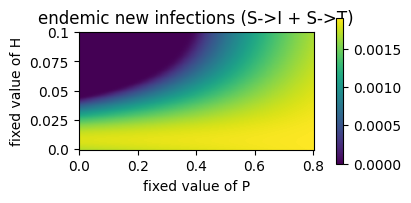

In [5]:
plt.figure(figsize=(4, 3), layout="constrained")
plt.imshow(res_infections, origin="lower")
plt.title("endemic new infections (S->I + S->T)")
plt.xlabel("fixed value of P")
plt.ylabel("fixed value of H")
plt.xticks([0, 50, 100, 150, 200], [Ps[0], Ps[50], Ps[100], Ps[150], Ps[200]])
plt.yticks([0, 25, 50, 75, 100], [Hs[0], Hs[25], Hs[50], Hs[75], Hs[100]])
plt.colorbar(shrink=0.5)

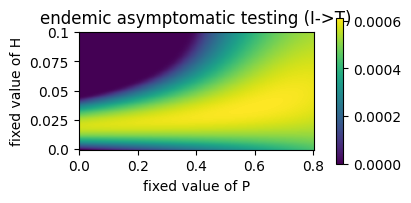

In [6]:
plt.figure(figsize=(4, 3), layout="constrained")
plt.imshow(res_tests, origin="lower")
plt.title("endemic asymptomatic testing (I->T)")
plt.xlabel("fixed value of P")
plt.ylabel("fixed value of H")
plt.xticks([0, 50, 100, 150, 200], [Ps[0], Ps[50], Ps[100], Ps[150], Ps[200]])
plt.yticks([0, 25, 50, 75, 100], [Hs[0], Hs[25], Hs[50], Hs[75], Hs[100]])
plt.colorbar(shrink=0.5)

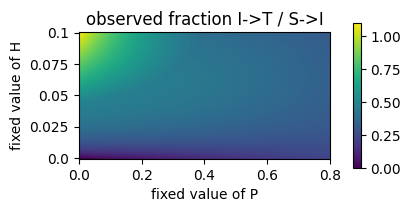

In [7]:
plt.figure(figsize=(4, 3), layout="constrained")
plt.imshow(res_tests / res_infections, origin="lower")
plt.title("observed fraction I->T / S->I")
plt.xlabel("fixed value of P")
plt.ylabel("fixed value of H")
plt.xticks([0, 50, 100, 150, 200], [Ps[0], Ps[50], Ps[100], Ps[150], Ps[200]])
plt.yticks([0, 25, 50, 75, 100], [Hs[0], Hs[25], Hs[50], Hs[75], Hs[100]])
plt.colorbar(shrink=0.5)

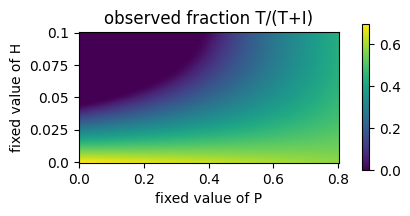

In [8]:
plt.figure(figsize=(4, 3), layout="constrained")
plt.imshow(res_I - res_T, origin="lower")
plt.title("observed fraction T/(T+I)")
plt.xlabel("fixed value of P")
plt.ylabel("fixed value of H")
plt.xticks([0, 50, 100, 150, 200], [Ps[0], Ps[50], Ps[100], Ps[150], Ps[200]])
plt.yticks([0, 25, 50, 75, 100], [Hs[0], Hs[25], Hs[50], Hs[75], Hs[100]])
plt.colorbar(shrink=0.5)

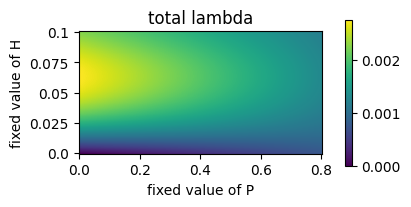

In [9]:
Hs = np.linspace(0, 0.1, 101)
Ps = np.linspace(0, 0.8, 201)
lambda_H = np.zeros([len(Hs), len(Ps)])
lambda_P = np.zeros([len(Hs), len(Ps)])
for i, H in enumerate(Hs):
    for j, P in enumerate(Ps):
        m = args["m_max"] - args["m_max"] / args["H_thres"] * args["m_eps"] * np.log(
            1 + np.exp((args["H_thres"] - H) / args["m_eps"])
        )
        lambda_H[i, j] = args["c"] * (1 - m) * args["beta_HIV"] * H * (1 - P)
        lambda_P[i, j] = args["lambda_P"] * P

plt.figure(figsize=(4, 3), layout="constrained")
plt.imshow(lambda_P + lambda_H + args["lambda_0"], origin="lower")
plt.title("total lambda")
plt.xlabel("fixed value of P")
plt.ylabel("fixed value of H")
plt.xticks([0, 50, 100, 150, 200], [Ps[0], Ps[50], Ps[100], Ps[150], Ps[200]])
plt.yticks([0, 25, 50, 75, 100], [Hs[0], Hs[25], Hs[50], Hs[75], Hs[100]])
plt.colorbar(shrink=0.5)